# Imports

In [383]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import folium
from branca.colormap import LinearColormap
import geodatasets
from shapely import wkt
from shapely.geometry import Point
import os
import imageio
from PIL import Image
from selenium import webdriver
from datetime import datetime
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from webdriver_manager.firefox import GeckoDriverManager
import time
import osmnx as ox
import networkx as nx

C:\Users\Daniel.DESKTOP-2H2HP2R\AppData\Local\Temp\ipykernel_6768\4286889953.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)  # Cache network data


# Data Preparation

### Working path directory

In [492]:
directory = "C:/Users/Daniel.DESKTOP-2H2HP2R/repos/hamburg_echarging/"

### Convert xlsx to csv

In [493]:
# Function
def convert_xls_to_csv(input_file, output_file, sheet_name=0):
    
    try:
        data = pd.read_excel(input_file, sheet_name=sheet_name)
        data.to_csv(output_file, index=False)
        print(f"Erfolgreich konvertiert: {input_file} -> {output_file}")
    except Exception as e:
        print(f"Fehler: {e}")

# Data
input_file = "dtv-dtvw-2004-2023-download-data.xlsx"
output_file = "dtv-dtvw-2004-2023-download-data.csv"

# Executing the function
convert_xls_to_csv(input_file, output_file)

### Load the Germany-wide charging station register and the Hamburg traffic volume

In [ ]:
# Loading CSV files
ladesaeulenregister = pd.read_csv(directory +'Ladesaeulenregister_01122024.csv', header = 0, encoding= 'unicode_escape', delimiter= ';')
verkehrsstaerke = pd.read_csv(directory +'dtv-dtvw-2004-2023-download-data.csv', header = 0, encoding= 'unicode_escape', delimiter= ',')
bedarfszaehlstellen = pd.read_csv(directory +'verkehrszaehlstellen_csv/app_kfz_bedarfszaehlstellen_EPSG_25832.csv', header = 0, encoding= 'unicode_escape', delimiter= ';')
dauerzaehlstellen = pd.read_csv(directory +'verkehrszaehlstellen_csv/app_kfz_dauerzaehlstellen_EPSG_25832.csv', header = 0, encoding= 'unicode_escape', delimiter= ';')
jahreszaehlstellen = pd.read_csv(directory +'verkehrszaehlstellen_csv/app_kfz_jaehrliche_zaehlstellen_EPSG_25832.csv', header = 0, encoding= 'unicode_escape', delimiter= ';')
pegel = pd.read_csv(directory +'verkehrszaehlstellen_csv/app_kfz_pegel_EPSG_25832.csv', header = 0, encoding= 'unicode_escape', delimiter= ';')

# Describing print-statements
# print(verkehrsstaerke['zaehlstelle'].describe())
# print(ladesaeulenregister['Betreiber'].describe())

C:\Users\Daniel.DESKTOP-2H2HP2R\AppData\Local\Temp\ipykernel_6768\3649124898.py:2: DtypeWarning: Columns (29,32) have mixed types. Specify dtype option on import or set low_memory=False.
  ladesaeulenregister = pd.read_csv(directory +'Ladesaeulenregister_01122024.csv', header = 0, encoding= 'unicode_escape', delimiter= ';')


### Merging CSV files

In [ ]:
zaehlstellen_all = pd.concat([bedarfszaehlstellen, dauerzaehlstellen, jahreszaehlstellen, pegel], axis=0, ignore_index=True)

zaehlstellen_all.to_csv("C:/Users/Daniel.DESKTOP-2H2HP2R/repos/hamburg_echarging/zaehlstellen_all.csv", index = False)

                                 ï»¿_fid  zaehlstelle  \
0     APP_KFZ_BEDARFSZAEHLSTELLEN_163670            2   
1     APP_KFZ_BEDARFSZAEHLSTELLEN_163671            3   
2     APP_KFZ_BEDARFSZAEHLSTELLEN_163672            5   
3     APP_KFZ_BEDARFSZAEHLSTELLEN_163673            6   
4     APP_KFZ_BEDARFSZAEHLSTELLEN_163674            7   
...                                  ...          ...   
2364                 APP_KFZ_PEGEL_37376         4088   
2365                 APP_KFZ_PEGEL_37377         4092   
2366                 APP_KFZ_PEGEL_37378         4094   
2367                 APP_KFZ_PEGEL_37379         4098   
2368                 APP_KFZ_PEGEL_37380         4102   

                                   bezeichnung  knoten letzte_zaehlung  \
0        Osdorfer LandstraÃe / WindmÃ¼hlenweg     NaN      01.01.2023   
1                Neue StraÃe / Harburger Ring     NaN      01.01.2023   
2     Elise-Averdieck-StraÃe / Oben Borgfelde     NaN      01.01.2024   
3          Oberhafe

In [312]:
# Merging the georeferenced Counting Points (from zaehlstellen_all.csv) with the Traffic Data (dtv-dtvw-2004-2023-download-data.csv)
georef_verkehr = verkehrsstaerke.merge(
    zaehlstellen_all[['zaehlstelle', 'geom', 'coordinate_reference_system']],
    on='zaehlstelle',
    how='left'  # “left” ensures that all lines from verkehrsstaerke are retained
)

# Save results
georef_verkehr.to_csv('georef_verkehr.csv', index=False)

# Print results
# print(georef_verkehr)

      zaehlstelle  Ebene                                     Bezeichnung  \
0            1013    371                    Krohnstieg NO Garstedter Weg   
1            1013    371                    Krohnstieg NO Garstedter Weg   
2            1013    371                    Krohnstieg NO Garstedter Weg   
3            1013    371                    Krohnstieg NO Garstedter Weg   
4            1017    372                    Garstedter Weg SW Krohnstieg   
...           ...    ...                                             ...   
1423         7459    221                    Hammer StraÃe NW Grenzknick   
1424         7621     96  EulenkrugstraÃe W Im Meienthun (Landesgrenze)   
1425         7621     96  EulenkrugstraÃe W Im Meienthun (Landesgrenze)   
1426         7621     96  EulenkrugstraÃe W Im Meienthun (Landesgrenze)   
1427         7621     96  EulenkrugstraÃe W Im Meienthun (Landesgrenze)   

                  Kategorie   2004   2005   2006   2007   2008   2009  ...  \
0        

### Filter Data

In [349]:
# Filter Counting Point Data by Hamburgs city borders,Fast Charging Stations and Time Series

# Apply filter: Only rows in which the federal state is “Hamburg”
hamburg_tabelle = ladesaeulenregister[(ladesaeulenregister['Bundesland'] == 'Hamburg') & (ladesaeulenregister['Art der Ladeeinrichtung'] == 'Schnellladeeinrichtung')]

# Replace commas with dots in the coordinate columns (Latitude and Longitude)
hamburg_tabelle['Laengengrad'] = hamburg_tabelle['Laengengrad'].str.replace(',', '.')
hamburg_tabelle['Breitengrad'] = hamburg_tabelle['Breitengrad'].str.replace(',', '.')

# Replace (some) formatting errors
hamburg_tabelle['Betreiber'] = hamburg_tabelle['Betreiber'].str.replace('ï¿½', 'ue')
hamburg_tabelle['Strasse'] = hamburg_tabelle['Strasse'].str.replace('straï¿½e', 'strasse')
hamburg_tabelle['Strasse'] = hamburg_tabelle['Strasse'].str.replace('Straï¿½e', 'Strasse')

# Convert "Inbetriebnahmedatum" to datetime (handling dd.mm.yy format)
hamburg_tabelle['Inbetriebnahmedatum'] = pd.to_datetime(
    hamburg_tabelle['Inbetriebnahmedatum'], 
    format='%d.%m.%Y', 
    errors='coerce'  # Coerce invalid dates to NaT
)

# Filter out rows where the year is 2024
hamburg_tabelle = hamburg_tabelle[
    hamburg_tabelle['Inbetriebnahmedatum'].dt.year != 2024
]

# Reset index
hamburg_tabelle = hamburg_tabelle.reset_index(drop=True)

# Save filtered table
hamburg_tabelle.to_csv('hamburg_tabelle.csv', index=False)

# Print filtered table
# print(hamburg_tabelle)
# print(hamburg_tabelle['Inbetriebnahmedatum'].describe())

                              Betreiber Anzeigename (Karte)  \
0                Shell Deutschland GmbH                 NaN   
1                Shell Deutschland GmbH                 NaN   
2      JET Tankstellen Deutschland GmbH                 NaN   
3                     NWG Charging GmbH        NWG Charging   
4     Hamburger Energiewerke Mobil GmbH          HEnW-Mobil   
..                                  ...                 ...   
209  Lidl Dienstleistung GmbH & Co. KGe                Lidl   
210   Hamburger Energiewerke Mobil GmbH          HEnW-Mobil   
211              Shell Deutschland GmbH                 NaN   
212              Shell Deutschland GmbH                 NaN   
213                  Comfortcharge GmbH      Comfort Charge   

                          Strasse Hausnummer    Adresszusatz  Postleitzahl  \
0                   Amsickstrasse         60             NaN       20097.0   
1                   Amsickstrasse         60             NaN       20097.0   
2        

C:\Users\Daniel.DESKTOP-2H2HP2R\AppData\Local\Temp\ipykernel_6768\2816473500.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hamburg_tabelle['Laengengrad'] = hamburg_tabelle['Laengengrad'].str.replace(',', '.')
C:\Users\Daniel.DESKTOP-2H2HP2R\AppData\Local\Temp\ipykernel_6768\2816473500.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hamburg_tabelle['Breitengrad'] = hamburg_tabelle['Breitengrad'].str.replace(',', '.')
C:\Users\Daniel.DESKTOP-2H2HP2R\AppData\Local\Temp\ipykernel_6768\2816473500.py:11

### Create a GeoDataFrame

In [508]:
# Add point geometries
geometry = gpd.points_from_xy(hamburg_tabelle.Laengengrad, hamburg_tabelle.Breitengrad)
gdf_charging_stations = gpd.GeoDataFrame(
    hamburg_tabelle,
    geometry=geometry
)
gdf_charging_stations.head()

,Betreiber,Anzeigename (Karte),Strasse,Hausnummer,Adresszusatz,Postleitzahl,Ort,Kreis/kreisfreie Stadt,Bundesland,Breitengrad,...,Steckertypen4,P4 [kW],Public Key4,Steckertypen5,P5 [kW],Public Key5,Steckertypen6,P6 [kW],Public Key6,geometry
0,Shell Deutschland GmbH,NaN,Amsickstrasse,60,NaN,20097.0,Hamburg,Kreisfreie Stadt Hamburg,Hamburg,53.543259,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.02174 53.54326)
1,Shell Deutschland GmbH,NaN,Amsickstrasse,60,NaN,20097.0,Hamburg,Kreisfreie Stadt Hamburg,Hamburg,53.543259,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.02174 53.54326)
2,JET Tankstellen Deutschland GmbH,NaN,Amsinckstrasse,73,NaN,20097.0,Hamburg,Kreisfreie Stadt Hamburg,Hamburg,53.542819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.02628 53.54282)
3,NWG Charging GmbH,NWG Charging,Auf der Brandshofer Schleuse,4,NaN,20097.0,Hamburg,Kreisfreie Stadt Hamburg,Hamburg,53.543119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.01493 53.54312)
4,Hamburger Energiewerke Mobil GmbH,HEnW-Mobil,Rothenbaumchaussee,60,NaN,20148.0,Hamburg,Kreisfreie Stadt Hamburg,Hamburg,53.56769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (9.98856 53.56769)


### Test Map Plot with MATPLOTLIB

In [497]:
df1 = pd.read_csv("hamburg_tabelle.csv")
# Keep only relevant columns
df = df1.loc[:, ("Betreiber", "Breitengrad", "Laengengrad")]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Betreiber    214 non-null    object 
 1   Breitengrad  214 non-null    float64
 2   Laengengrad  214 non-null    float64
dtypes: float64(2), object(1)
memory usage: 5.1+ KB


In [506]:
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

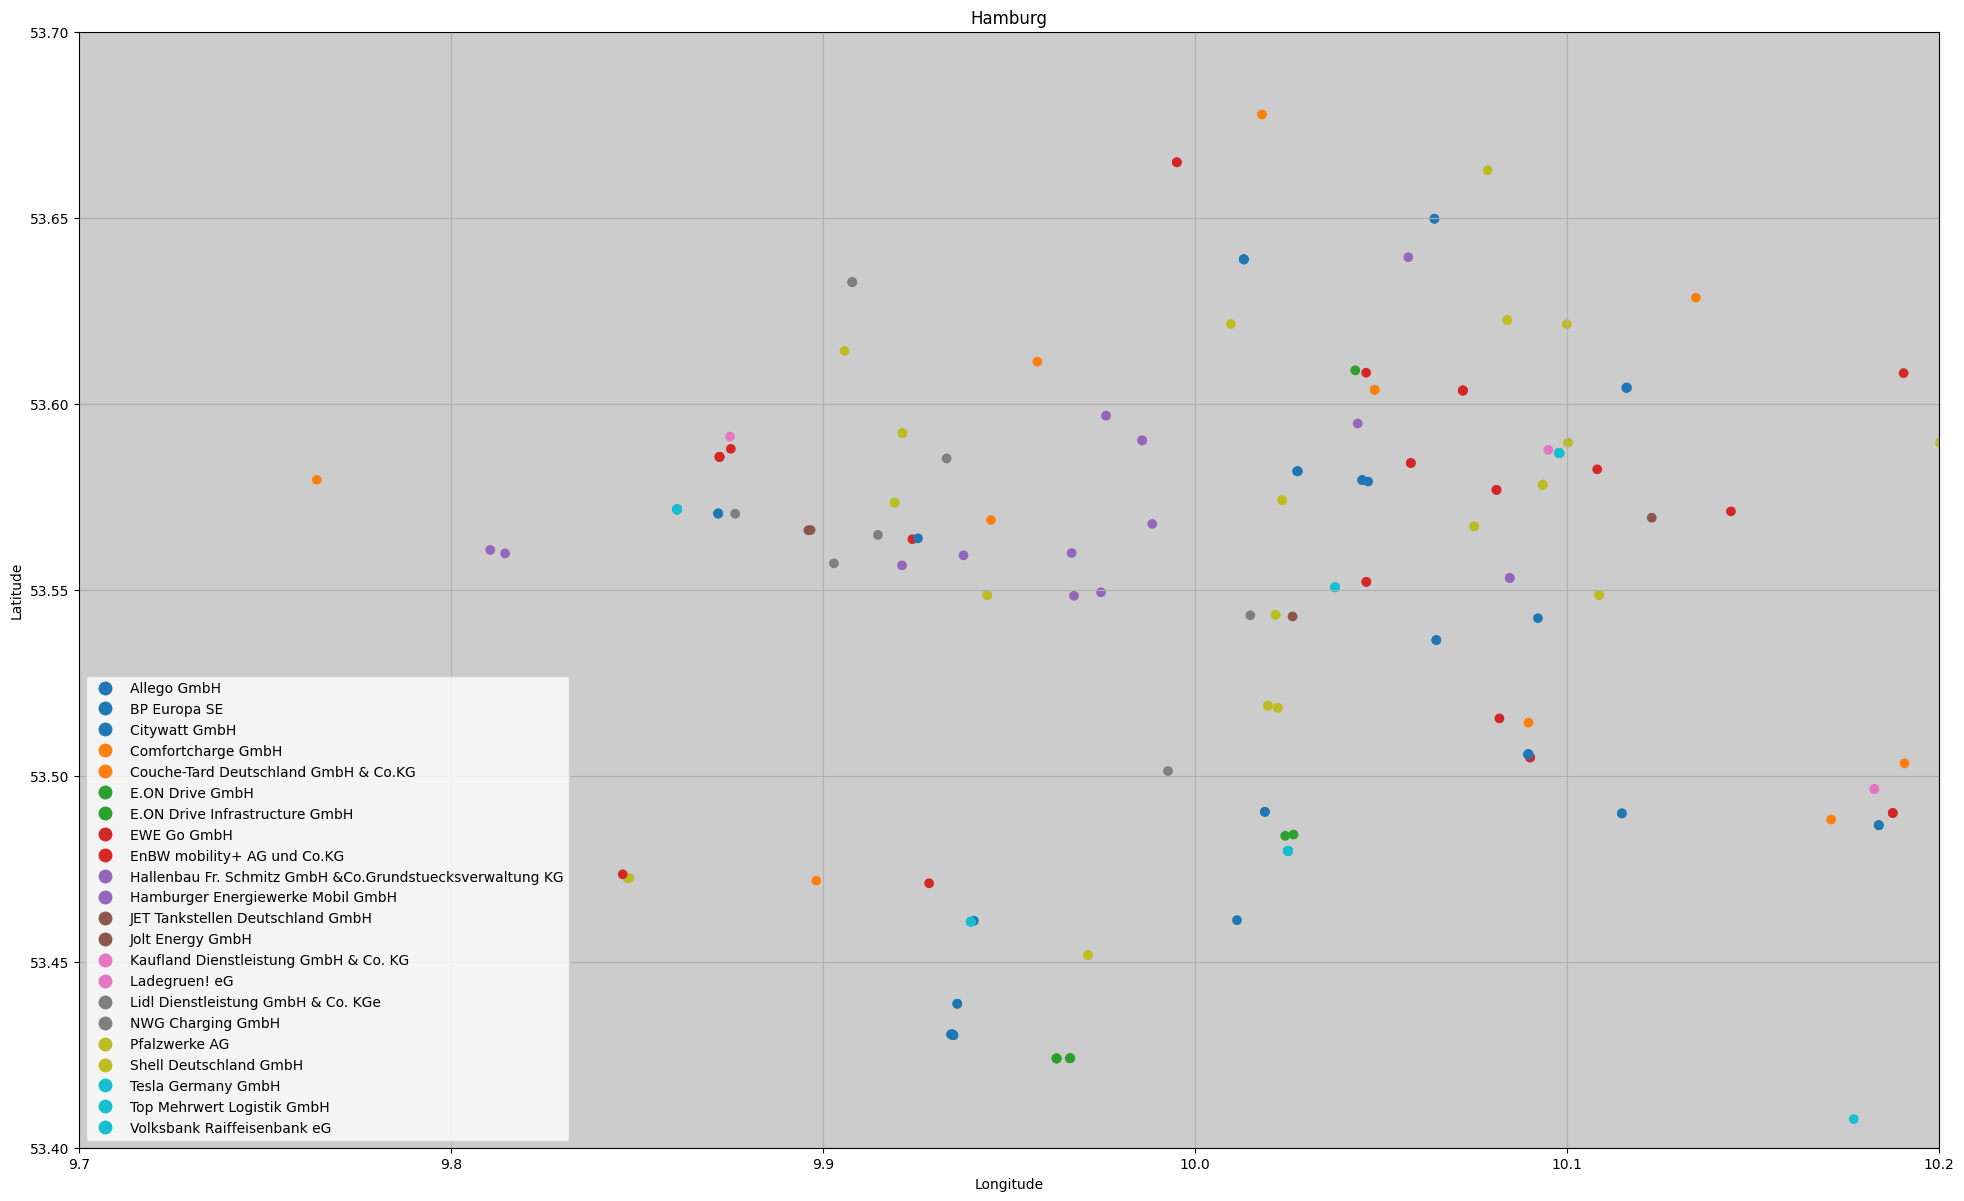

In [ ]:
fig, ax = plt.subplots(figsize=(24, 18))
world.plot(ax=ax, alpha=0.4, color="grey")
gdf_charging_stations.plot(column="Betreiber", ax=ax, legend=True)

# Set title
plt.title("Hamburg")

# Add coordinate labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Set zoom level by defining axis limits
ax.set_xlim(9.7, 10.2)  # Longitude range
ax.set_ylim(53.4, 53.7)  # Latitude range

# Add grid
ax.grid(True)

# Statistics

## New EV Fast Charging Stations per Year

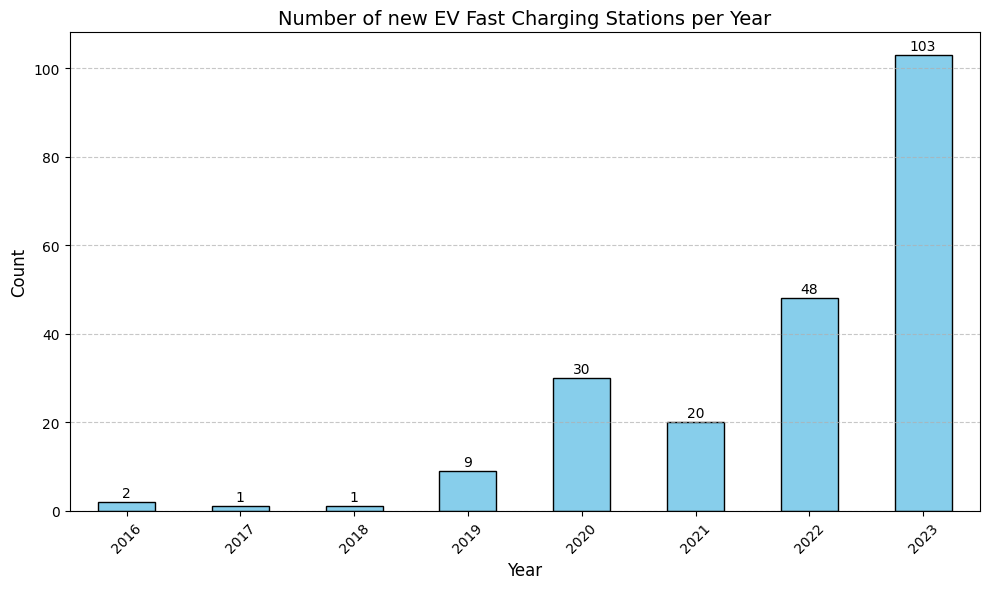

In [510]:
# Load data and extract years
years = gdf_charging_stations["Inbetriebnahmedatum"].dt.year
year_counts = years.dropna().value_counts().sort_index()

# Create the plot
plt.figure(figsize=(10, 6))
bars = year_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add exact counts on top of each bar
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-position (center of bar)
        bar.get_height() + 0.5,             # y-position (slightly above bar)
        f'{int(bar.get_height())}',         # text (count value)
        ha='center',                        # horizontal alignment
        va='bottom',                        # vertical alignment
        fontsize=10
    )

# Customize the plot
plt.title("Number of new EV Fast Charging Stations per Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Passenger Vehicles in 2023

72980
740664


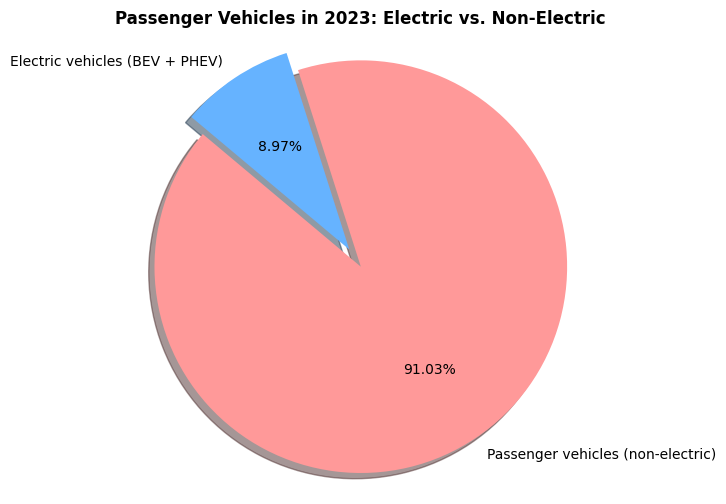

In [511]:
all_electro = np.sum(E) + np.sum(P)  # Total electric vehicles
print(all_electro)
all_passenger_vehicles = 813644      # Total passenger vehicles in 2023
all_passenger_vehicles_wo_electro = all_passenger_vehicles - all_electro
print(all_passenger_vehicles_wo_electro)

# Labels and sizes for the pie chart
labels = ['Passenger vehicles (non-electric)', 'Electric vehicles (BEV + PHEV)']
sizes = [all_passenger_vehicles_wo_electro, all_electro]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # Explode the 1st slice

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct='%1.2f%%',
    shadow=True,
    startangle=140
)
plt.title('Passenger Vehicles in 2023: Electric vs. Non-Electric', fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart
plt.show()

## EV vs Plugin per Year

In [ ]:
# https://www.kba.de/DE/Statistik/Produktkatalog/produkte/Fahrzeuge/fz13_b_uebersicht.html;jsessionid=3F4CAFEC87BFE643BB7571F6368ECAC7.live11311?nn=4543062
# 2023: 13.186 (E), 4.356 (P)
# 2022: 13078(E), 14481(P)
# 2021: 7334 (E), 8295 (P)
# 2020: 3395(E), 2502(P)
# 2019: 1395 (E), 1227 (P)
# 2018: 1126 (E), 879 (P)
# 2017: 608 (E), 760 (P)
# 2016: 358 (E), - (P)

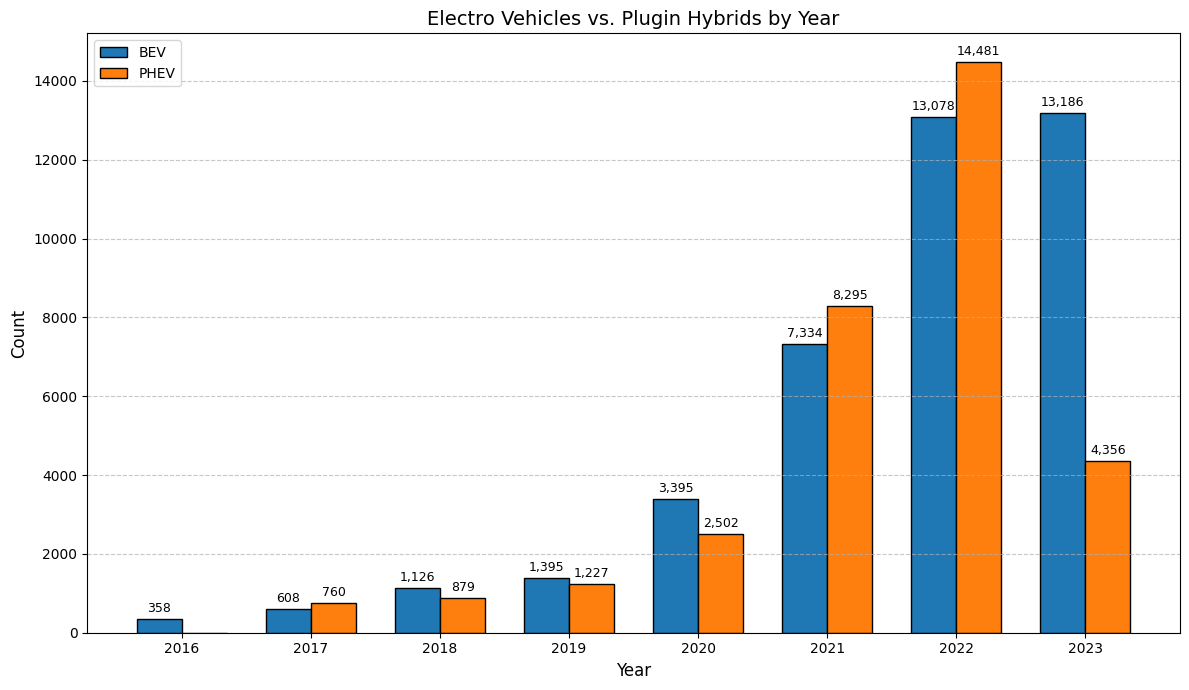

In [512]:
# Data
years = np.array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])
E = np.array([358, 608, 1126, 1395, 3395, 7334, 13078, 13186])
P = np.array([0, 760, 879, 1227, 2502, 8295, 14481, 4356])  # 2016 P set to 0 (missing)

# Plot
plt.figure(figsize=(12, 7))
width = 0.35  # Bar width

# Create bars
bars_E = plt.bar(years - width/2, E, width, label='BEV', color='#1f77b4', edgecolor='black')
bars_P = plt.bar(years + width/2, P, width, label='PHEV', color='#ff7f0e', edgecolor='black')

# Add counts on top of bars
for bars in [bars_E, bars_P]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Skip zero (2016 P)
            plt.text(bar.get_x() + bar.get_width()/2, height + 100,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# Customize
plt.title("Electro Vehicles vs. Plugin Hybrids by Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(years)
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plotting Maps with FOLIUM

## Operator Map

In [514]:
# Prepare the data
betreibers = gdf_charging_stations["Betreiber"].unique()
n_betreibers = len(betreibers)
print(n_betreibers)

# Generate a color palette
colors = LinearColormap(
    colors=["#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#A133FF", "#33FFF5", "#FFC300", "#FF6F33", "#33FFBD", "#8D33FF", "#FF3333", "#33D4FF", "#C70039", "#900C3F", "#DAF7A6", 
    "#581845", "#1ABC9C", "#2ECC71", "#3498DB", "#9B59B6", "#34495E", "#F39C12", "#D35400", "#7F8C8D" ],
    index=range(n_betreibers), 
    vmin=0, 
    vmax=n_betreibers
).to_step(n_betreibers)

# Map each Betreiber to a color
betreiber_color_map = {
    betreiber: colors(i) 
    for i, betreiber in enumerate(betreibers)
}

# Create the map
m = folium.Map(
    location=[gdf_charging_stations.geometry.centroid.y.mean(), gdf_charging_stations.geometry.centroid.x.mean()],
    zoom_start=12
)

# Add colored markers (no popup)
for idx, row in gdf_charging_stations.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,  # Adjust size
        color=betreiber_color_map[row["Betreiber"]],
        fill=True,
        fill_color=betreiber_color_map[row["Betreiber"]],
    ).add_to(m)

# Add a legend
legend = '''
     <div style="position: fixed; 
                 bottom: 50px; right: 50px; width: 300px; height: auto; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white; padding: 10px;">
         <b>Operator Legend</b><br>
         {}
     </div>
'''.format(
    '<br>'.join([
        f'<i style="background:{betreiber_color_map[betreiber]}; width: 15px; height: 15px; display: inline-block;"></i> {betreiber}'
        for betreiber in betreibers
    ])
)

m.get_root().html.add_child(folium.Element(legend))

m  # Display



22


## Provider Heatmap

In [ ]:
from folium import plugins

map = folium.Map(location=[53.6503, 9.9728], tiles="Cartodb dark_matter", zoom_start=10)

heat_data = [[point.xy[1][0], point.xy[0][0]] for point in gdf_charging_stations.geometry]

heat_data
plugins.HeatMap(heat_data).add_to(map)

map

## Traffic Heatmap (Locations)

In [362]:
# Check if geom is a string
print(type(georef_verkehr.geom.iloc[0]))
print(traffic_df.geom)

<class 'str'>
0       POINT (564489.000000 5944555.000000)
1       POINT (564489.000000 5944555.000000)
2       POINT (564489.000000 5944555.000000)
3       POINT (564489.000000 5944555.000000)
4       POINT (564402.000000 5944460.000000)
                        ...                 
1423    POINT (570825.000000 5935165.000000)
1424    POINT (578726.000000 5944586.000000)
1425    POINT (578726.000000 5944586.000000)
1426    POINT (578726.000000 5944586.000000)
1427    POINT (578726.000000 5944586.000000)
Name: geom, Length: 1428, dtype: object


In [ ]:
# Read CSV
df = pd.read_csv("georef_verkehr.csv", encoding='utf-8')

# Clean the geom column
# Drop rows where geom is NaN or not a string
df = df.dropna(subset=['geom'])
df['geom'] = df['geom'].astype(str)  # Force string type

# Parse WKT safely (skip invalid geometries)
def safe_wkt_load(x):
    try:
        return wkt.loads(x)
    except:
        return None

df['geom'] = df['geom'].apply(safe_wkt_load)

# Drop rows where geometry parsing failed
df = df.dropna(subset=['geom'])

# Create GeoDataFrame
gdf_traffic = gpd.GeoDataFrame(
    df,
    geometry='geom',
    crs="EPSG:25832"  # UTM Zone 32N (adjust if needed)
)

print(gdf_traffic.head())

   zaehlstelle  Ebene                   Bezeichnung              Kategorie  \
0         1013    371  Krohnstieg NO Garstedter Weg          DTV (Kfz/24h)   
1         1013    371  Krohnstieg NO Garstedter Weg         DTVw (Kfz/24h)   
2         1013    371  Krohnstieg NO Garstedter Weg  SV-Anteil am DTVw (%)   
3         1013    371  Krohnstieg NO Garstedter Weg     Baustelleneinfluss   
4         1017    372  Garstedter Weg SW Krohnstieg          DTV (Kfz/24h)   

    2004   2005   2006   2007   2008   2009  ...   2016   2017   2018   2019  \
0  51000  52000  52000  53000  52000  52000  ...  51000  52000  51000  51000   
1  56000  56000  57000  58000  57000  56000  ...  56000  56000  56000  56000   
2      6      6      6      6      6      6  ...      5      4      5      5   
3    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN   
4  12000  11000  11000  11000  11000  11000  ...  13000  12000  12000  12000   

    2020   2021   2022   2023                     

In [429]:
# Convert UTM (EPSG:25832) to Lat/Lon (EPSG:4326)
#gdf_traffic = gdf_traffic.to_crs("EPSG:4326")  # Reproject to WGS84

# Create Folium map centered on Hamburg
map = folium.Map(location=[53.5506, 9.9937],  # Hamburg coordinates
                 tiles="Cartodb dark_matter", 
                 zoom_start=11)

# Prepare heatmap data as [lat, lon] pairs
heat_data = [[point.y, point.x] for point in gdf_traffic.geometry]  # Note: y=lat, x=lon

# Add HeatMap layer
plugins.HeatMap(heat_data, radius=15, blur=10).add_to(map)  # Adjust radius/blur as needed

# Display the map
map

## Traffic Heatmap (Strength)

In [ ]:
# Read CSV (ensure correct encoding)
df = pd.read_csv("georef_verkehr.csv", encoding='utf-8')  # or 'latin-1'

# Filter rows: Keep only "DTV (Kfz/24h)" in 'Kategorie'
df = df[df['Kategorie'] == "DTV (Kfz/24h)"]

# Clean geom column (drop rows where geom is NaN or invalid WKT)
df = df[df['geom'].notna()]
df['geom'] = df['geom'].astype(str)

# Parse WKT safely (skip invalid geometries)
def safe_wkt_load(x):
    try:
        return wkt.loads(x)
    except:
        return None

df['geom'] = df['geom'].apply(safe_wkt_load)
df = df[df['geom'].notna()]

# Create GeoDataFrame (UTM Zone 32N)
gdf_traffic = gpd.GeoDataFrame(
    df,
    geometry='geom',
    crs="EPSG:25832"
)

# Convert to Lat/Lon (WGS84)
gdf_traffic = gdf_traffic.to_crs("EPSG:4326")

# Select a year (e.g., 2023) and ensure counts are numeric
year = "2023"
gdf_traffic[year] = pd.to_numeric(gdf_traffic[year], errors='coerce')  # Convert to float, NaN if invalid
gdf_traffic = gdf_traffic[gdf_traffic[year].notna()]  # Drop NaN counts

# Prepare heatmap data: [lat, lon, weight]
heat_data = [
    [point.y, point.x, float(count)]  # Explicitly convert to float
    for point, count in zip(gdf_traffic.geometry, gdf_traffic[year])
]

# Verify heat_data has no NaNs
assert not any(np.isnan(x[-1]) for x in heat_data), "Heatmap data contains NaNs!"

# Create Folium map (Hamburg)
m = folium.Map(
    location=[53.5506, 9.9937],
    tiles="Cartodb dark_matter", 
    zoom_start=11
)

# Add weighted HeatMap
plugins.HeatMap(
    heat_data,
    radius=15,
    blur=10,
    max_zoom=12,
    min_opacity=0.3,
    # Gradient fix: use string keys or a different approach
    gradient={'0.4': 'blue', '0.6': 'lime', '0.8': 'yellow', '1': 'red'}
).add_to(m)

# Save or display
m

## Combination of Traffic Heatmap and Charging Stations

In [370]:
# 1. Prepare the data
betreibers = gdf_charging_stations["Betreiber"].unique()
n_betreibers = len(betreibers)
print(n_betreibers)

# 2. Generate a color palette
colors = LinearColormap(
    colors=["#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#A133FF", 
            "#33FFF5", "#FFC300", "#FF6F33", "#33FFBD", "#8D33FF",
            "#FF3333", "#33D4FF", "#C70039", "#900C3F", "#DAF7A6",
            "#581845", "#1ABC9C", "#2ECC71", "#3498DB", "#9B59B6",
            "#34495E", "#F39C12", "#D35400", "#7F8C8D"],
    index=range(n_betreibers), 
    vmin=0, 
    vmax=n_betreibers
).to_step(n_betreibers)

# 3. Map each Betreiber to a color
betreiber_color_map = {
    betreiber: colors(i) 
    for i, betreiber in enumerate(betreibers)
}

# 4. Create the base map with dark theme
m = folium.Map(
    location=[gdf_charging_stations.geometry.centroid.y.mean(), gdf_charging_stations.geometry.centroid.x.mean()],
    tiles="Cartodb dark_matter",
    zoom_start=12
)

# 8. Prepare heatmap data: [lat, lon, weight]
heat_data = [
    [point.y, point.x, float(count)]  # Explicitly convert to float
    for point, count in zip(gdf_traffic.geometry, gdf_traffic[year])
]


# 11. Add weighted HeatMap
plugins.HeatMap(
    heat_data,
    radius=15,
    blur=10,
    max_zoom=12,
    min_opacity=0.3,
    # Gradient fix: use string keys or a different approach
    gradient={'0.4': 'blue', '0.6': 'lime', '0.8': 'yellow', '1': 'red'}
).add_to(m)

# 6. Add colored markers for charging stations on top
for idx, row in gdf_charging_stations.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color=betreiber_color_map[row["Betreiber"]],
        fill=True,
        fill_color=betreiber_color_map[row["Betreiber"]],
        fill_opacity=0.7  # Slightly transparent to see heatmap underneath
    ).add_to(m)

# 7. Add a combined legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; right: 50px; width: 300px; height: auto; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white; padding: 10px;">
         <b>Map Legend</b><br>
         <p><b>Charging Station Operators:</b></p>
         {}
         <p><b>Heatmap:</b> Traffic density</p>
     </div>
'''.format(
    '<br>'.join([
        f'<i style="background:{betreiber_color_map[betreiber]}; width: 15px; height: 15px; display: inline-block;"></i> {betreiber}'
        for betreiber in betreibers
    ])
)

m.get_root().html.add_child(folium.Element(legend_html))

# 8. Display the map
m

22


# Creating GIFs

## GIF of Yearly Charging Stations Development

### Save maps as html

In [ ]:
# Read the CSV file
df = pd.read_csv('hamburg_tabelle.csv', parse_dates=['Inbetriebnahmedatum'], dayfirst=True)

# Extract year from the date column
df['Year'] = df['Inbetriebnahmedatum'].dt.year

# Get unique years and sort them
unique_years = sorted(df['Year'].unique())

# Create output directory if it doesn't exist
os.makedirs('yearly_maps', exist_ok=True)

# Create a map for each year
for year in unique_years:
    print(f"Processing year {year}...")
    
    # Filter data for the current year
    year_data = df[df['Year'] == year]
    
    # Create a NEW map for each year (don't copy)
    m = folium.Map(
        location=[53.5506, 9.9937], 
        zoom_start=10, 
        tiles="cartodbpositron", 
        attr="CartoDB Positron"
    )
    
    # Add a title to the map (fixed version)
    title_html = '''
        <h3 align="center" style="font-size:16px">
            <b>Charging Stations Operational in {}</b>
        </h3>
    '''.format(year)
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Add markers for each charging station
    for idx, row in year_data.iterrows():
        folium.CircleMarker(
            location=[row['Breitengrad'], row['Laengengrad']],
            radius=3,
            color='blue',
            fill=True,
            fill_color='blue',
            popup=f"{row['Betreiber']}<br>Inbetriebnahmedatum: {row['Inbetriebnahmedatum'].strftime('%d.%m.%Y')}"
        ).add_to(m)
    
    # Save the map as HTML
    m.save(f'yearly_maps/charging_stations_{year}.html')
    
    print(f"Saved map for {year}")

print("All yearly maps created successfully!")

### Convert html files to pngs

In [ ]:
# Set up Firefox options
options = Options()
options.add_argument('--headless')  # Run in background
options.add_argument('--disable-gpu')
options.set_preference('devtools.jsonview.enabled', False)
options.set_preference('general.useragent.override', 'Mozilla/5.0')

# Initialize Firefox WebDriver (auto-downloads GeckoDriver if needed)
driver = webdriver.Firefox(
    service=Service(GeckoDriverManager().install()),
    options=options
)

# Set window size (adjust as needed)
driver.set_window_size(1200, 800)

# Convert each HTML file to PNG
for year in unique_years:
    html_path = f'yearly_maps/charging_stations_{year}.html'
    png_path = f'yearly_maps/charging_stations_{year}.png'
    
    # Open HTML file in Firefox
    driver.get(f'file://{os.path.abspath(html_path)}')
    
    # Wait for map to load
    time.sleep(2)  # Adjust delay if needed
    
    # Take screenshot
    driver.save_screenshot(png_path)
    
    # Crop the image (optional)
    img = Image.open(png_path)
    img = img.crop((0, 0, 1200, 800))  # Adjust crop area
    img.save(png_path)
    
    print(f"Converted {year} to PNG")

driver.quit()
print("All HTML files converted to PNG using Firefox!")

### Create GIF

In [ ]:
# List all PNG files sorted by year
png_files = sorted([f for f in os.listdir('yearly_maps') if f.endswith('.png')])

# Open images and convert to RGB (required for GIF)
images = [Image.open(f"yearly_maps/{f}").convert('RGB') for f in png_files]

# Save as GIF (adjust `duration` in milliseconds)
images[0].save(
    'charging_stations_evolution.gif',
    save_all=True,
    append_images=images[1:],
    duration=1000,  # Time per frame (ms)
    loop=0         # 0 = infinite loop
)

## GIF of Yearly Traffic

### Save maps as html

In [371]:
# 1. Read and prepare data
df = pd.read_csv('georef_verkehr.csv', encoding='utf-8')

# Filter for "DTV (Kfz/24h)" if needed
df = df[df['Kategorie'] == "DTV (Kfz/24h)"]

# 2. Clean geometry and convert to lat/lon
def safe_wkt_load(x):
    try:
        return wkt.loads(x)
    except:
        return None

df['geom'] = df['geom'].astype(str).apply(safe_wkt_load)
gdf = gpd.GeoDataFrame(df.dropna(subset=['geom']), geometry='geom', crs="EPSG:25832")
gdf = gdf.to_crs("EPSG:4326")

# 3. Create yearly heatmaps (2016-2023)
os.makedirs('yearly_traffic_maps', exist_ok=True)

for year in range(2016, 2024):
    year_col = str(year)
    print(f"Processing {year_col}...")
    
    # Filter valid data points
    year_data = gdf[gdf[year_col].notna()]
    year_data[year_col] = pd.to_numeric(year_data[year_col], errors='coerce')
    year_data = year_data[year_data[year_col] > 0]  # Remove zeros
    
    # Create heatmap data [lat, lon, weight]
    heat_data = [[point.y, point.x, count] 
                for point, count in zip(year_data.geometry, year_data[year_col])]
    
    # Create map
    m = folium.Map(location=[53.5506, 9.9937], 
                  tiles="Cartodb dark_matter", 
                  zoom_start=11)
    
    # Add title
    title_html = f'''
        <h3 align="center" style="font-size:16px">
            <b>Traffic Volume (Kfz/24h) in {year_col}</b>
        </h3>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Add heatmap (with safe gradient)
    plugins.HeatMap(
        heat_data,
        radius=15,
        blur=10,
        min_opacity=0.3,
        gradient={'0.1': 'blue', '0.3': 'cyan', '0.5': 'lime', '0.7': 'yellow', '1': 'red'}
    ).add_to(m)
    
    # Save
    m.save(f'yearly_traffic_maps/traffic_{year_col}.html')

print("All yearly traffic maps created!")

Processing 2016...
Processing 2017...
Processing 2018...
Processing 2019...
Processing 2020...
Processing 2021...
Processing 2022...
Processing 2023...
All yearly traffic maps created!


c:\Users\Daniel.DESKTOP-2H2HP2R\miniforge3\envs\GIS1\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Convert html files to pngs

In [235]:
# Set up Firefox options
options = Options()
options.add_argument('--headless')  # Run in background
options.add_argument('--disable-gpu')
options.set_preference('devtools.jsonview.enabled', False)
options.set_preference('general.useragent.override', 'Mozilla/5.0')

# Initialize Firefox WebDriver (auto-downloads GeckoDriver if needed)
driver = webdriver.Firefox(
    service=Service(GeckoDriverManager().install()),
    options=options
)

# Set window size (adjust as needed)
driver.set_window_size(1200, 800)

# Convert each HTML file to PNG
for year in unique_years:
    html_path = f'yearly_traffic_maps/traffic_{year}.html'
    png_path = f'yearly_traffic_maps/traffic_{year}.png'
    
    # Open HTML file in Firefox
    driver.get(f'file://{os.path.abspath(html_path)}')
    
    # Wait for map to load
    time.sleep(2)  # Adjust delay if needed
    
    # Take screenshot
    driver.save_screenshot(png_path)
    
    # Crop the image (optional)
    img = Image.open(png_path)
    img = img.crop((0, 0, 1200, 800))  # Adjust crop area
    img.save(png_path)
    
    print(f"Converted {year} to PNG")

driver.quit()
print("All HTML files converted to PNG using Firefox!")

C:\Users\Daniel.DESKTOP-2H2HP2R\AppData\Local\Temp\ipykernel_6768\2951798524.py:10: DeprecationWarning: Firefox will soon stop logging to geckodriver.log by default; Specify desired logs with log_output
  service=Service(GeckoDriverManager().install()),


Converted 2016 to PNG
Converted 2017 to PNG
Converted 2018 to PNG
Converted 2019 to PNG
Converted 2020 to PNG
Converted 2021 to PNG
Converted 2022 to PNG
Converted 2023 to PNG


WebDriverException: Message: Reached error page: about:neterror?e=fileNotFound&u=file%3A///c%3A/Users/Daniel.DESKTOP-2H2HP2R/repos/hamburg_echarging/yearly_traffic_maps/traffic_2024.html&c=UTF-8&d=Die%20Dateien%20unter%20/c%3A/Users/Daniel.DESKTOP-2H2HP2R/repos/hamburg_echarging/yearly_traffic_maps/traffic_2024.html%20konnten%20nicht%20gefunden%20werden.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:197:5
UnknownError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:869:5
checkReadyState@chrome://remote/content/marionette/navigate.sys.mjs:58:24
onNavigation@chrome://remote/content/marionette/navigate.sys.mjs:347:39
emit@resource://gre/modules/EventEmitter.sys.mjs:148:20
receiveMessage@chrome://remote/content/marionette/actors/MarionetteEventsParent.sys.mjs:33:25


### Create GIF

In [236]:
# List all PNG files sorted by year
png_files = sorted([f for f in os.listdir('yearly_traffic_maps') if f.endswith('.png')])

# Open images and convert to RGB (required for GIF)
images = [Image.open(f"yearly_traffic_maps/{f}").convert('RGB') for f in png_files]

# Save as GIF (adjust `duration` in milliseconds)
images[0].save(
    'traffic_evolution.gif',
    save_all=True,
    append_images=images[1:],
    duration=1000,  # Time per frame (ms)
    loop=0         # 0 = infinite loop
)

# Analysis with OSMNX and NETWORKX

In [372]:
hamburg_network = ox.graph_from_place(
    "Hamburg, Germany", 
    network_type="drive",  # "drive", "walk", "bike"
    simplify=True
)

In [373]:
# Get nearest network node for each EV charger
ev_nodes = []
for geom in gdf_charging_stations.geometry:
    nearest_node = ox.distance.nearest_nodes(
        hamburg_network, 
        geom.x, 
        geom.y
    )
    ev_nodes.append(nearest_node)

# Get nearest nodes for traffic sensors
traffic_nodes = []
for geom in gdf_traffic.geometry:
    nearest_node = ox.distance.nearest_nodes(
        hamburg_network, 
        geom.x, 
        geom.y
    )
    traffic_nodes.append(nearest_node)

In [374]:
# Add edge travel times (assuming speed=50 km/h)
hamburg_network = ox.add_edge_speeds(hamburg_network)
hamburg_network = ox.add_edge_travel_times(hamburg_network)

# Compute shortest paths
reachability = {}
for traffic_node in traffic_nodes:
    distances = nx.single_source_dijkstra_path_length(
        hamburg_network, 
        traffic_node, 
        weight="travel_time"
    )
    # Find nearest EV charger
    min_distance = float('inf')
    nearest_ev = None
    for ev_node in ev_nodes:
        if distances.get(ev_node, float('inf')) < min_distance:
            min_distance = distances[ev_node]
            nearest_ev = ev_node
    reachability[traffic_node] = {
        "nearest_ev": nearest_ev,
        "travel_time": min_distance
    }

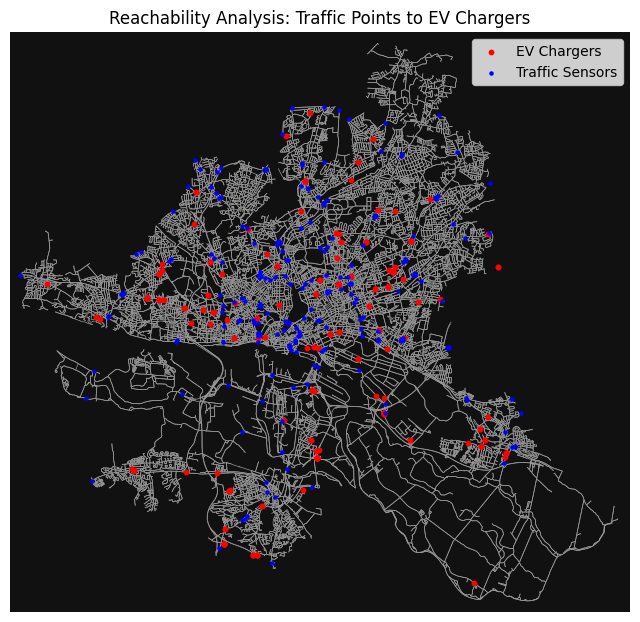

In [ ]:
# Plot network with critical points
fig, ax = ox.plot_graph(
    hamburg_network, 
    node_size=0, 
    edge_linewidth=0.5,
    show=False, 
    close=False
)

# Add EV chargers (red) and traffic points (blue)
gdf_charging_stations.plot(ax=ax, color="red", markersize=10, label="EV Chargers")
gdf_traffic.plot(ax=ax, color="blue", markersize=5, label="Traffic Sensors")

plt.legend()
plt.title("Reachability Analysis: Traffic Points to EV Chargers")
plt.show()

In [376]:
# Input data
traffic_data = gdf_traffic['2023'].unique()

# Compute statistics
min_val = np.min(traffic_data)
max_val = np.max(traffic_data)
mean_val = np.mean(traffic_data)
median_val = np.median(traffic_data)
q1 = np.percentile(traffic_data, 25)
q3 = np.percentile(traffic_data, 75)

# Print key stats
print("=== Key Statistics ===")
print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Mean: {mean_val:.0f}")
print(f"Median: {median_val:.0f}")
print(f"Q1 (25th percentile): {q1:.0f}")
print(f"Q3 (75th percentile): {q3:.0f}\n")

# Define thresholds (using intuitive ranges)
low_threshold = q1
high_threshold = q3

# Categorize traffic
def categorize_traffic(value):
    if value <= low_threshold:
        return "Low"
    elif value <= high_threshold:
        return "Medium"
    else:
        return "High"

# Apply categorization
categorized_data = [(value, categorize_traffic(value)) for value in traffic_data]

# Print results
print("=== Categorized Traffic ===")
for value, category in categorized_data:
    print(f"{value:6} → {category}")

# Count values in each category
from collections import Counter
category_counts = Counter(category for _, category in categorized_data)

print("\n=== Counts per Category ===")
for category, count in category_counts.items():
    print(f"{category}: {count} values")

=== Key Statistics ===
Min: 3000.0
Max: 112000.0
Mean: 30612
Median: 28000
Q1 (25th percentile): 16000
Q3 (75th percentile): 42000

=== Categorized Traffic ===
48000.0 → High
9000.0 → Low
42000.0 → Medium
46000.0 → High
21000.0 → Medium
25000.0 → Medium
39000.0 → Medium
33000.0 → Medium
32000.0 → Medium
51000.0 → High
15000.0 → Low
29000.0 → Medium
112000.0 → High
14000.0 → Low
5000.0 → Low
8000.0 → Low
11000.0 → Low
6000.0 → Low
20000.0 → Medium
30000.0 → Medium
50000.0 → High
18000.0 → Medium
10000.0 → Low
52000.0 → High
12000.0 → Low
13000.0 → Low
22000.0 → Medium
16000.0 → Low
28000.0 → Medium
26000.0 → Medium
17000.0 → Medium
34000.0 → Medium
31000.0 → Medium
27000.0 → Medium
7000.0 → Low
23000.0 → Medium
24000.0 → Medium
38000.0 → Medium
3000.0 → Low
37000.0 → Medium
64000.0 → High
44000.0 → High
53000.0 → High
35000.0 → Medium
54000.0 → High
19000.0 → Medium
60000.0 → High
40000.0 → Medium
47000.0 → High

=== Counts per Category ===
High: 12 values
Low: 13 values
Medium: 24 valu

In [377]:
# Filter into categories
gdf_traffic_low = gdf_traffic[gdf_traffic['2023'] < 16000].copy()
gdf_traffic_medium = gdf_traffic[(gdf_traffic['2023'] >= 16001) & (gdf_traffic['2023'] <= 42000)].copy()
gdf_traffic_high = gdf_traffic[gdf_traffic['2023'] > 42000].copy()

# Add category labels for reference
gdf_traffic_low['traffic_category'] = 'low'
gdf_traffic_medium['traffic_category'] = 'medium'
gdf_traffic_high['traffic_category'] = 'high'

# Validation prints
print(f"Total stations: {len(gdf_traffic)}")
print(f"Low traffic stations (<16,000): {len(gdf_traffic_low)}")
print(f"Medium traffic stations (16,001-42,000): {len(gdf_traffic_medium)}")
print(f"High traffic stations (>42,000): {len(gdf_traffic_high)}")

print("\nSample from each category:")
print("Low traffic sample:\n", gdf_traffic_low[['2023', 'geom']].head(2))
print("\nMedium traffic sample:\n", gdf_traffic_medium[['2023', 'geom']].head(2))
print("\nHigh traffic sample:\n", gdf_traffic_high[['2023', 'geom']].head(2))

# Optional: Check if any stations were missed
total_filtered = len(gdf_traffic_low) + len(gdf_traffic_medium) + len(gdf_traffic_high)
print(f"\nValidation: {total_filtered} of {len(gdf_traffic)} stations categorized ({len(gdf_traffic) - total_filtered} missing if any)")

Total stations: 211
Low traffic stations (<16,000): 88
Medium traffic stations (16,001-42,000): 97
High traffic stations (>42,000): 17

Sample from each category:
Low traffic sample:
        2023                       geom
4    9000.0   POINT (9.97424 53.64494)
60  15000.0  POINT (10.00376 53.54642)

Medium traffic sample:
        2023                       geom
8   42000.0   POINT (9.97385 53.64546)
12  42000.0  POINT (10.00963 53.63582)

High traffic sample:
        2023                      geom
0   48000.0  POINT (9.97557 53.64579)
16  46000.0  POINT (9.95257 53.61327)

Validation: 202 of 211 stations categorized (9 missing if any)


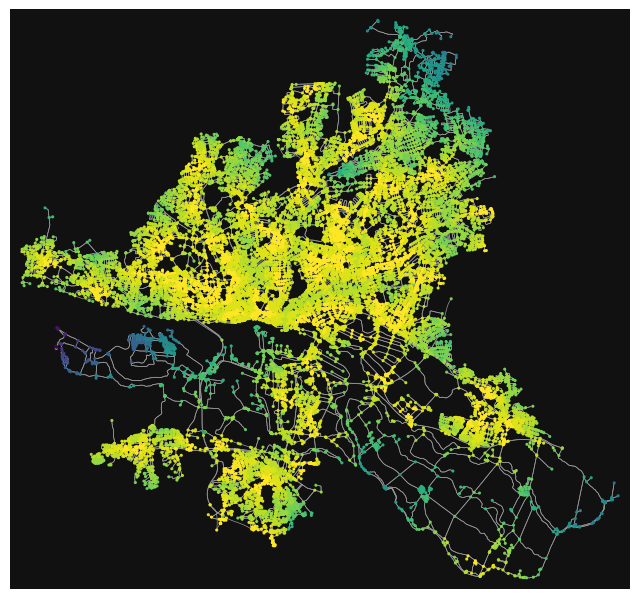

In [378]:
# Load graph and prepare
G = ox.graph_from_place("Hamburg, Germany", network_type="drive", simplify=True)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# Get nodes for your points (with validation)
def get_valid_nodes(points, G):
    valid_nodes = []
    for point in points.geometry:
        try:
            node = ox.distance.nearest_nodes(G, point.x, point.y)
            if node in G:  # Verify node exists in graph
                valid_nodes.append(node)
        except Exception as e:
            print(f"Skipping point at ({point.x}, {point.y}): {str(e)}")
    return valid_nodes

traffic_nodes = get_valid_nodes(gdf_traffic, G)
ev_nodes = get_valid_nodes(gdf_charging_stations, G)

# Calculate reachability with safe min()
for node in G.nodes():
    try:
        travel_times = nx.single_source_dijkstra_path_length(G, node, weight='travel_time')
        # Filter to only reachable EV nodes
        reachable_times = [travel_times[ev] for ev in ev_nodes if ev in travel_times]
        if reachable_times:  # Only store if at least one EV is reachable
            G.nodes[node]['time_to_ev'] = min(reachable_times)
        else:
            G.nodes[node]['time_to_ev'] = np.nan  # Mark unreachable
    except nx.NetworkXNoPath:
        G.nodes[node]['time_to_ev'] = np.nan

# Visualize (filter out NaN nodes)
valid_nodes = [n for n in G.nodes() if 'time_to_ev' in G.nodes[n] and not np.isnan(G.nodes[n]['time_to_ev'])]
times = [G.nodes[n]['time_to_ev'] for n in valid_nodes]

nc = ox.plot.get_node_colors_by_attr(
    G.subgraph(valid_nodes), 
    'time_to_ev', 
    cmap='viridis_r', 
    num_bins=20
)
fig, ax = ox.plot_graph(
    G.subgraph(valid_nodes),
    node_color=nc,
    node_size=5,
    edge_linewidth=0.5
)

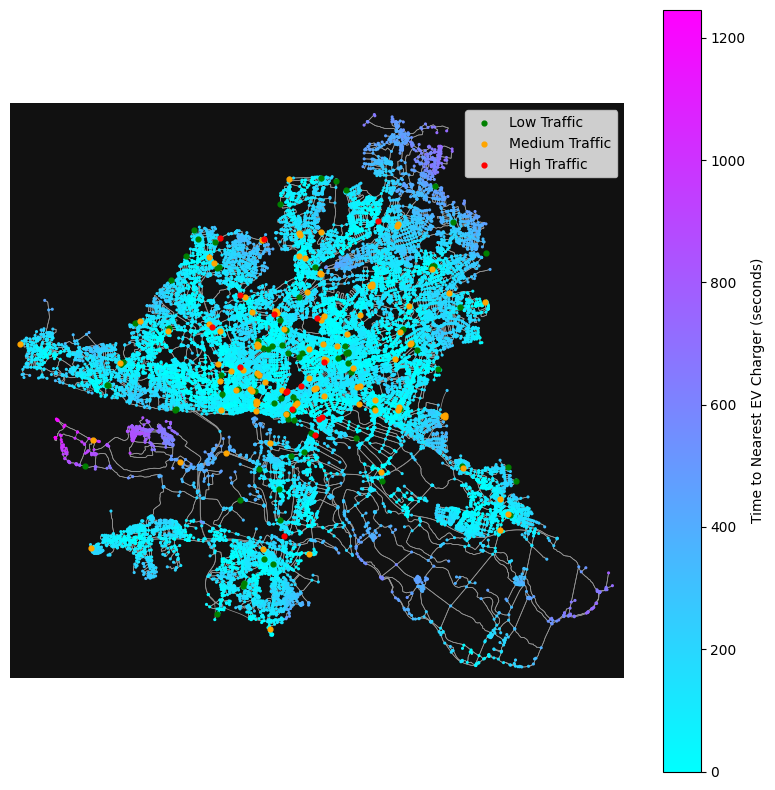

In [384]:
# Create figure and axis
fig, ax = ox.plot_graph(
    G.subgraph(valid_nodes),
    node_color=ox.plot.get_node_colors_by_attr(
    G.subgraph(valid_nodes), 
    'time_to_ev', 
    cmap='cool', 
    num_bins=20
),
    node_size=5,
    edge_linewidth=0.5,
    show=False,
    close=False
)

# Add EV chargers and traffic sensors
# gdf_charging_stations.plot(ax=ax, color='red', markersize=20, label='EV Chargers')
gdf_traffic_low.plot(ax=ax, color='green', markersize=12, label='Low Traffic')
gdf_traffic_medium.plot(ax=ax, color='orange', markersize=12, label='Medium Traffic')
gdf_traffic_high.plot(ax=ax, color='red', markersize=12, label='High Traffic')

# Create colorbar
sm = ScalarMappable(cmap='cool', 
                   norm=Normalize(vmin=min(times), vmax=max(times)))
sm.set_array([])  # Required for empty array trick
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Time to Nearest EV Charger (seconds)')

plt.legend()
plt.tight_layout()
plt.show()

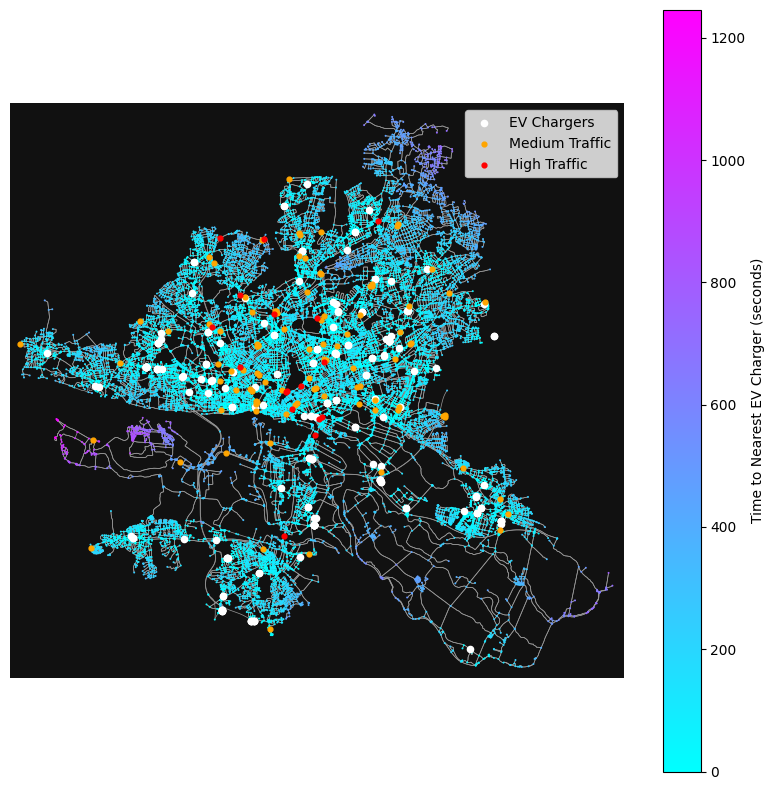

In [ ]:
# Create figure and axis
fig, ax = ox.plot_graph(
    G.subgraph(valid_nodes),
    node_color=ox.plot.get_node_colors_by_attr(
    G.subgraph(valid_nodes), 
    'time_to_ev', 
    cmap='cool', 
    num_bins=20
),
    node_size=2,
    edge_linewidth=0.5,
    show=False,
    close=False
)

# Add EV chargers and traffic sensors
gdf_charging_stations.plot(ax=ax, color='white', markersize=20, label='EV Chargers')
# gdf_traffic_low.plot(ax=ax, color='green', markersize=12, label='Low Traffic')
gdf_traffic_medium.plot(ax=ax, color='orange', markersize=12, label='Medium Traffic')
gdf_traffic_high.plot(ax=ax, color='red', markersize=12, label='High Traffic')

# Create colorbar
sm = ScalarMappable(cmap='cool', 
                   norm=Normalize(vmin=min(times), vmax=max(times)))
sm.set_array([])  # Required for empty array trick
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Time to Nearest EV Charger (seconds)')

plt.legend()
plt.tight_layout()
plt.show()

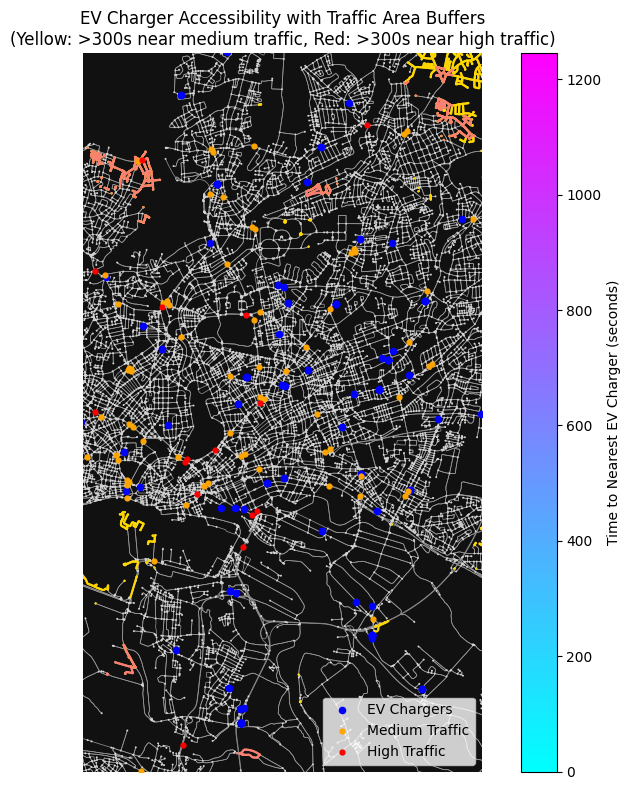

In [480]:
# Load graph and prepare
G = ox.graph_from_place("Hamburg, Germany", network_type="drive", simplify=True)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# Get nodes for your points (with validation)
def get_valid_nodes(points, G):
    valid_nodes = []
    for point in points.geometry:
        try:
            node = ox.distance.nearest_nodes(G, point.x, point.y)
            if node in G:  # Verify node exists in graph
                valid_nodes.append(node)
        except Exception as e:
            print(f"Skipping point at ({point.x}, {point.y}): {str(e)}")
    return valid_nodes

traffic_nodes = get_valid_nodes(gdf_traffic, G)
ev_nodes = get_valid_nodes(gdf_charging_stations, G)

# Calculate reachability with safe min()
for node in G.nodes():
    try:
        travel_times = nx.single_source_dijkstra_path_length(G, node, weight='travel_time')
        # Filter to only reachable EV nodes
        reachable_times = [travel_times[ev] for ev in ev_nodes if ev in travel_times]
        if reachable_times:  # Only store if at least one EV is reachable
            G.nodes[node]['time_to_ev'] = min(reachable_times)
        else:
            G.nodes[node]['time_to_ev'] = np.nan  # Mark unreachable
    except nx.NetworkXNoPath:
        G.nodes[node]['time_to_ev'] = np.nan

# Calculate buffers around medium/high traffic locations with >300s to EV charger
medium_traffic_nodes = get_valid_nodes(gdf_traffic_medium, G)
high_traffic_nodes = get_valid_nodes(gdf_traffic_high, G)

# Create masks for nodes in the buffers
for node in G.nodes():
    # Initialize buffer flags
    G.nodes[node]['medium_traffic_buffer'] = False
    G.nodes[node]['high_traffic_buffer'] = False
    
    # Check if node is in medium traffic buffer (>300s to EV)
    if 'time_to_ev' in G.nodes[node] and not np.isnan(G.nodes[node]['time_to_ev']):
        if G.nodes[node]['time_to_ev'] > 300:
            # Check distance to medium traffic nodes
            for mt_node in medium_traffic_nodes:
                try:
                    tt = nx.shortest_path_length(G, node, mt_node, weight='travel_time')
                    if tt <= 300:  # Within 300s of medium traffic node
                        G.nodes[node]['medium_traffic_buffer'] = True
                        break
                except nx.NetworkXNoPath:
                    continue
            
            # Check distance to high traffic nodes
            for ht_node in high_traffic_nodes:
                try:
                    tt = nx.shortest_path_length(G, node, ht_node, weight='travel_time')
                    if tt <= 300:  # Within 300s of high traffic node
                        G.nodes[node]['high_traffic_buffer'] = True
                        break
                except nx.NetworkXNoPath:
                    continue

# Prepare data for visualization
valid_nodes = [n for n in G.nodes() if 'time_to_ev' in G.nodes[n] and not np.isnan(G.nodes[n]['time_to_ev'])]
times = [G.nodes[n]['time_to_ev'] for n in valid_nodes]

# Highlight nodes in buffers with distinct colors
medium_buffer_nodes = [n for n in valid_nodes if G.nodes[n]['medium_traffic_buffer']]
high_buffer_nodes = [n for n in valid_nodes if G.nodes[n]['high_traffic_buffer']]

# Create colorbar for time to EV
sm = ScalarMappable(cmap='cool', norm=Normalize(vmin=min(times), vmax=max(times)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Time to Nearest EV Charger (seconds)')

# Get bounds from the full graph
nodes = ox.graph_to_gdfs(G, edges=False)
minx, miny, maxx, maxy = nodes.total_bounds

# Create figure with enforced bounds
fig, ax = ox.plot_graph(
    G,
    node_color='lightgray',
    node_size=0,  # Hide base nodes (only show edges)
    edge_color='lightgray',
    edge_linewidth=0.5,
    show=False,
    close=False,
    bbox=(minx, miny, maxx, maxy)
)

# Plot buffers
ox.plot_graph(
    G.subgraph(medium_buffer_nodes),
    node_color='gold',
    node_size=3,
    edge_color='gold',
    edge_linewidth=1.5,
    ax=ax,
    show=False,
    close=False,
    bbox=(minx, miny, maxx, maxy)
)

ox.plot_graph(
    G.subgraph(high_buffer_nodes),
    node_color='salmon',
    node_size=3,
    edge_color='salmon',
    edge_linewidth=1.5,
    ax=ax,
    show=False,
    close=False,
    bbox=(minx, miny, maxx, maxy)
)

# Manually enforce bounds (extra safety)
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

# Add EV chargers and traffic sensors
gdf_charging_stations.plot(ax=ax, color='blue', markersize=20, label='EV Chargers')
gdf_traffic_medium.plot(ax=ax, color='orange', markersize=12, label='Medium Traffic')
gdf_traffic_high.plot(ax=ax, color='red', markersize=12, label='High Traffic')

# Add colorbar, legend, etc. (your existing code)
plt.legend()
plt.title('EV Charger Accessibility with Traffic Area Buffers\n(Yellow: >300s near medium traffic, Red: >300s near high traffic)')
plt.tight_layout()
plt.show()

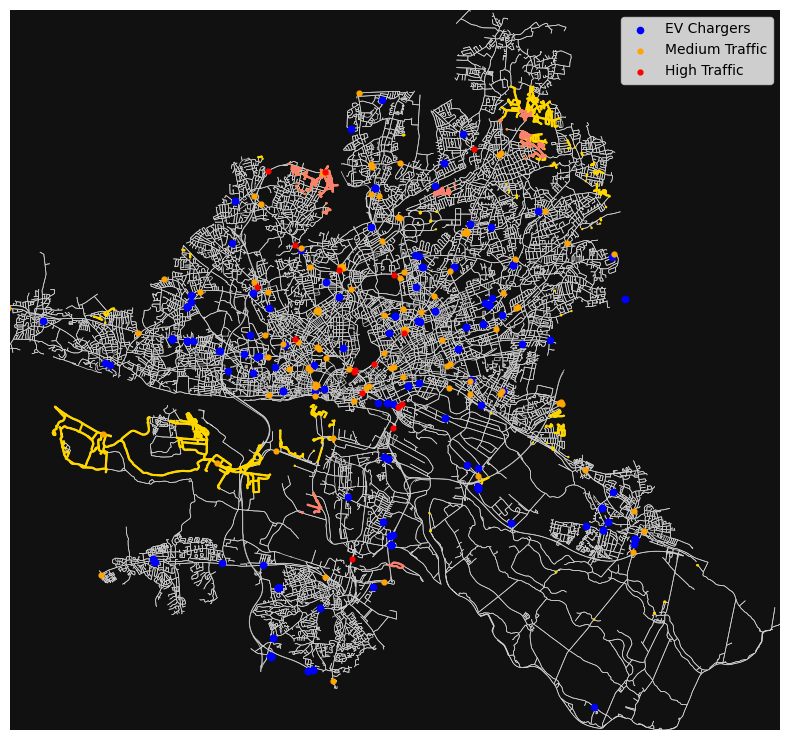

# References

In [ ]:
# GIS 1 Scripts
# https://pandas.pydata.org/pandas-docs/stable/
# https://geopandas.org/en/stable/gallery/plotting_with_folium.html
# https://geopandas.org/en/stable/docs.html
# https://osmnx.readthedocs.io/en/stable/
# https://networkx.org/documentation/stable/reference/introduction.html
# Help, suggestions, inspirations from ChatGPT and DeepSeek